# Wrap-up

## 31/03/2022 - Preliminary Results

- Two main scenarios
    - **Computer Vision(CV)-like**: 20 base classes + big increments of 5, 10, and 20
    - **Traffic Classification (TC)-like**: 34 base classes + small incremnts of 1, 2, and 3
- Sensitivity analysis (on Finetuning and SS-IL) of considered scenarios to tune hyperparamenters of
    - Patience in 5, 10, 20
    - Batch size in 32, 64, 128
    - Trade-off selected patience of **20 and batch size of 64**
- Dissecting the old vs new bevavior of F1 Score
    - Approaches were **grouped** by the different behaviors
- Finetuning suffers from no catastrophic forgetting
    - Further inspect issues

## 07/04/2022 - Preliminary Results

- Re-definition of auxiliary metrics of
    - **Forgetting**
    - **Intransigence**
- Evaluation of all the approaches in the considered scenarios over more random repetitions
    - BiC almost always the best or 2nd-best
    - No stable behavior, thinking about **ranking procedures**
- Finetuning hyperparamenters comparison
    - Momentum: 0.9 (original) vs 0 (current)
    - LR-decay: 10 (original) vs 3 (current)
    - Best configuration selected is the **original**

## 13/04/2022 - Preliminary Results

- Refining of auxiliry metrics of
    - **Drop from the Scratch** for old and all classes
    - Intransigence treated as a Drop from the Scratch for new Classes
    - **Incoherence**, in order to replace the t-SNE visualization (very confusing)
- Impact of the activation on features vector
    - Comparison between the usage of positive values in features vector against the entire range of values
    - Selected the one uses the **entire range of features vector values**

In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import argparse
import functools
import hashlib
import itertools
import json
import os
import sys
from copy import deepcopy
from functools import partial
from glob import glob
from multiprocessing import Pool
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import portalocker as pl
import seaborn as sns
from matplotlib import cm
from tqdm import tqdm
from matplotlib.lines import Line2D

from plot_metrics import preprocess_metrics

sns.set_style('whitegrid')

In [90]:
def get_ts(df_filename):
    return '-'.join(df_filename.split('/')[-1].split('-')[1:]).split('_')[0]

def get_args_dict(df_filename):
    ts = get_ts(df_filename)
    try:
        with open('/'.join(df_filename.split('/')[:-2] + ['args-%s.txt' % ts])) as fin:
            return json.loads(fin.read())
    except FileNotFoundError as _:
        with open('/'.join(df_filename.split('/')[:-1] + ['args-%s.txt' % ts])) as fin:
            return json.loads(fin.read())

In [5]:
appr_dict = {'icarl': 'iCaRL', 'icarlo': 'iCaRL-original', 'icarlp': 'iCaRL+', 'bic': 'BiC', 'il2m': 'IL2M',
             'lwf': 'LwF', 'finetuning': 'FT+', 'lucir': 'LUCIR', 'ewc': 'EWC', 'joint': 'Joint',
             'scratch': 'Scratch', 'freezing': 'FZ+', 'eeil': 'EEIL', 'ssil': 'SSIL', 'jointft': 'FT',
            'backbonefreezing': 'FZ'}

metr_dict = {'accuracy_score': 'Accuracy', 'balanced_accuracy_score': 'Balanced Accuracy', 'f1_score': 'F1 Score',
             'precision_score': 'Precision', 'recall_score': 'Recall', 'top_k_accuracy_score': 'Top k Accuracy'}
metr_dict.update(
    dict([('forgetting_%s' % k, '%s Forgetting' % v) for k, v in metr_dict.items()])
)
mety_dict = {
    'normal': {
        'all': 'All',
        'old': 'Old',
        'new': 'New'
    },
    'expectation': 'Expectation',
    'intransigence': {
        'all': 'Drop All',
        'old': 'Drop Old',
        'new': 'Intransigence'
    }}
cols_dict = {'approach': 'Approach', 'network': 'Network', 'nc_incr_tasks': 'Increment',
             'batch_size': 'Batch Size', 'lr_patience': 'Patience', 'type': 'Type',
             'out_features_size': 'Out Features Size', 'momentum': 'Momentum'}

In [6]:
def load_data(df_filenames, compute_drops=False):
    df = pd.DataFrame()
    for df_filename in tqdm(df_filenames):
        args_dict = get_args_dict(df_filename)
        tmp_df = pd.read_parquet(df_filename)
        if 'nc_first_task' in tmp_df:
            tmp_df_g = tmp_df.groupby(['nc_first_task', 'nc_incr_tasks'])
        else:
            tmp_df_g = [((args_dict['nc_first_task'], args_dict['nc_incr_tasks']), tmp_df)]
        
        row = {'Seed': args_dict['seed'], 'Network': args_dict['network'],
               'Approach': '%s' % appr_dict[args_dict['approach']], 'Batch Size': args_dict['batch_size'],
               'Patience': args_dict['lr_patience'],
               'Out Features Size': args_dict.get('out_features_size', 200),
               'Momentum': args_dict.get('momentum', .0),
               'First Momentum': args_dict.get('first_momentum', .0)}
        
        for g, tmp_d in tmp_df_g:
            _nc_first_task = g[0]
            _nc_incr_tasks = g[1]

            f1s = [[v0 * 100 for v0 in v] for v in tmp_d['f1_score'].values]
            try:
                incs_e = [[v0 * 100 for v0 in v] for v in tmp_d['incoherence_score_euclidean'].values]
                incs_m = [[v0 * 100 for v0 in v] for v in tmp_d['incoherence_score_mahalanobis'].values]
                ss = [[v0 for v0 in v] for v in tmp_d['silhouette_score'].values]
            except KeyError as _:
                incs_e = incs_m = ss = np.zeros((len(f1s), len(f1s[0])))
            
            row.update({'Increment': _nc_incr_tasks})
            for ep, (f1, inc_e, inc_m, s) in enumerate(zip(f1s, incs_e, incs_m, ss)):
                for t in ['Base', 'Old', 'New', 'Avg']:
                    if ep == 0 and t in ['Old', 'New']:
                        continue
                    if ep > 0 and t == 'Base':
                        continue
                    _f1 = np.mean(f1) if t in ['Base', 'Avg'] else np.mean(f1[:-int(_nc_incr_tasks)]) if t == 'Old' else np.mean(f1[-int(_nc_incr_tasks):])
                    _inc_e = np.mean(inc_e) if t in ['Base', 'Avg'] else np.mean(inc_e[:-int(_nc_incr_tasks)]) if t == 'Old' else np.mean(inc_e[-int(_nc_incr_tasks):])
                    _inc_m = np.mean(inc_m) if t in ['Base', 'Avg'] else np.mean(inc_m[:-int(_nc_incr_tasks)]) if t == 'Old' else np.mean(inc_m[-int(_nc_incr_tasks):])
                    _s = np.mean(s) if t in ['Base', 'Avg'] else np.mean(s[:-int(_nc_incr_tasks)]) if t == 'Old' else np.mean(s[-int(_nc_incr_tasks):])
                    n_classes = _nc_first_task + _nc_incr_tasks * ep
                    row.update({
                        'Episode': ep,
                        '#Classes': n_classes,
                        'F1 Score': _f1,
                        'Incoherence Euclidean': _inc_e,
                        'Incoherence Mahalanobis': _inc_m,
                        'Corrected Incoherence Euclidean': _inc_e * (n_classes - 1),
                        'Corrected Incoherence Mahalanobis': _inc_m * (n_classes - 1),
                        'Silhouette': _s,
                        'Type': t
                    })
                    df = df.append(row, ignore_index=True)
    if compute_drops:
        df_UB = df[df['Approach'] == 'Scratch'].reset_index(drop=True)
        df = df[df['Approach'] != 'Scratch'].reset_index(drop=True)
        
        columns = ['Seed', 'Network', 'Batch Size', 'Patience', 'Out Features Size', 'Type', '#Classes']
        
        df_g = df.groupby(columns)
        groups = list(df_g.groups)
        del df_g
        for group in groups:
            df_filter = functools.reduce(lambda x, y: x & y, [df[col] == g for col, g in zip(columns, group)])
            df_UB_filter = functools.reduce(lambda x, y: x & y, [df_UB[col] == g for col, g in zip(columns, group)])
            
            if not len(df_UB.loc[df_UB_filter]):
                print('WARNING: group (%s) does not present Upperbound model.' % ', '.join([str(v) for v in group]))
                continue
            else:
                for metric in ['F1 Score']:#, 'Incoherence', 'Corrected Incoherence']:
                    ub_value = df_UB.loc[df_UB_filter, metric].values[0]
                    df.loc[df_filter, '%s Drop' % metric] = df.loc[df_filter, metric].apply(lambda x: ub_value - x)

    return df

In [7]:
def get_stdout_list(df_filename):
    with open(df_filename) as fin:
        return [v.strip() for v in fin.readlines()]

def get_training_info(stdout_filenames):
    #print("start2")
    train_columns = ['Seed', 'Task', 'Epoch', 'Train Time', 'Validation Time', 'Validation Loss', 'TAw Accuracy',
                     'Learning Rate']
    timing_columns = ['Approach', 'Seed', 'Type', 'Task', 'Time', 'Num Samples']
    df_train = pd.DataFrame(columns=train_columns)
    df_timing = pd.DataFrame(columns=timing_columns)
    for filename in tqdm(stdout_filenames):
        #if filename != '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/mirage_generic_finetuning_finetuning_momentum_base20_incr5_stop2/stdout-1650811345.txt':
            #print('Preprocessing %s' % filename)
            #print(filename)
            stdout_list = get_stdout_list(filename)

            # read args_dict
            with open(filename.replace('stdout', 'args')) as fin:
                args_dict = json.loads(fin.read())

            row_train = {'Seed': int(args_dict['seed']), 'First Momentum': args_dict.get('first_momentum', 0), 'Base Momentum': args_dict.get('momentum', 0)}
            #row_timing = {'Seed': int(args_dict['seed']), 'First Momentum': args_dict.get('first_momentum', 0), 'Base Momentum': args_dict.get('momentum', 0)}    
            row_timing = {'Approach': (args_dict['approach']), 'Seed': int(args_dict['seed']), 'First Momentum': args_dict.get('first_momentum', 0), 'Base Momentum': args_dict.get('momentum', 0)}    
            #print(row_timing)
            lr = float(args_dict['lr'])
            for line in stdout_list:
                #print(line)
                if 'Task' in line and 'BiC' not in line:
                    task = int(line.split(' ')[-1])
                if 'Epoch' in line and 'Valid' in line:
                    row_train.update({'Learning Rate': lr})
                    row_train.update({'Task': task})
                    line_s = line.split('|')
                    row_train.update({'Epoch': int(line_s[1].split(' ')[-3][:-1])})
                    row_train.update({'Train Time': float(line_s[1].split(' ')[-2].split('=')[-1][:-1])})
                    row_train.update({'Validation Loss': float(line_s[3].split(' ')[3].split('=')[-1][:-1])})
                    row_train.update({'Validation Time': float(line_s[3].split(' ')[2].split('=')[-1][:-1])})
                    row_train.update({'TAw Accuracy': float(line_s[3].split('=')[-1][:-2])})
                    df_train = df_train.append(row_train, ignore_index=True)
                    if 'lr' in line:
                        lr = float(line_s[4].split('=')[-1].replace(',', '.'))
                if 'Train Time' in line:
                    for i in np.arange(3):
                        row_timing.update({'Task': task})
                        row_timing.update({'Type': line.split(' ')[3 + i].split('=')[0]})
                        row_timing.update({'Time': float(line.split(' ')[3 + i].split('=')[1][:-2])})
                        df_timing = df_timing.append(row_timing, ignore_index=True)
                if 'Test' in line:
                    row_timing.update({'Num Samples': line.split(' ')[-2]})
                    # row_timing.update({'Task': int(line.split(' ')[5])})
                    row_timing.update({'Task': task})
                    row_timing.update({'Type': 'Test'})
                    row_timing.update({'Time': float(line.split('time=')[1].split(' ')[1][:-1])})
                    df_timing = df_timing.append(row_timing, ignore_index=True)
                    row_timing.update({'Num Samples': 'NaN'})

        # saving dataframe
        #path_index = filename.rfind('/')
        #df_train_filename = filename[:path_index] + '/results/df_train.parquet'
        #df_timing_filename = filename[:path_index] + '/results/df_timing.parquet'
        #df_train.to_parquet(df_train_filename)
        #df_timing.to_parquet(df_timing_filename)
    return df_train, df_timing


# Incoherence Assessment

## Goal 
Evaluate the Incoherence metric against Classification Performance metrics (i.e. F1 Score) and Number of Classes.

The Incoherence metric is unbounded, and no hints are available to discriminate good/bad values but comparison. The main objective is to empirically assess the properties of such metric, in order to better interpretate it.

## Configuration

### First Configuration

Multiple executions starting from *different sets of base classes* and performing a *single increment*.

**Number of Base Classes**: 2, 4, 8, 16, 32

**Size of Increments**: 2, 4, 8

**Approach**: BiC

### Second Configuration

Multiple executions with *different sized sets of base classes*, *w/o performing increments*.

**Number of Base Classes**: 20-40

**Size of Increments**: None

**Approach**: Scratch

## Comment 

The Incoherence as defined in DISTILLER is strongly dependent on the Number of Classes, thus undermining comparison when this latter varies.
Accordingly, a *corrected* version of Incoherence, named **Corrected Incoherence** is proposed.

The original version of the Incoherence is defined as:

### $$I_\mathcal{c} = \frac{\sum^{S}_{i} d_{i,\mathcal{c}}}{\sum^{S}_{i}\sum^{N}_{j \ne i}d_{i,j}}$$

where $d_{a,b}$ is the distance (Euclidean or Mahalanobis) between each sample belonging the class $a$ and the centroid of class $b$, and $N$ **is the number of classes**.

The Corrected Incoherence follows:

### $$I^C_\mathcal{c} = I_i\cdot (N-1)$$

resulting in an **Incoherence independent from the number of classes**.

From the analysis it is clear that:

- F1 Score is inversely proportional w.r.t. Number of Classes (**desiderable**)
- Incoherence is inversely proportional w.r.t. Number of Classes (undesiderable)
- Corrected Incoherence shows no dependence w.r.t. Number of Classes (**desiderable**)
- Incoherence is directly proportional w.r.t. the F1 Score (undesiderable)
- Corrected Incoherence in inversely proportional w.r.t. the F1 Score (**desiderable**)

In [51]:
exp_name = 'incoherence_assessment'
results_path = '../hf-project/results'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
# df_filenames.extend(glob('%s_UB/**/*%s.parquet' % (results_path, analysis), recursive=True))
df_incoherence_incr = load_data(df_filenames, compute_drops=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:18<00:00,  8.79it/s]


In [52]:
df_incoherence_incr

,Seed,Network,Approach,Batch Size,Patience,Out Features Size,Momentum,First Momentum,Increment,Episode,#Classes,F1 Score,Incoherence Euclidean,Incoherence Mahalanobis,Corrected Incoherence Euclidean,Corrected Incoherence Mahalanobis,Silhouette,Type
0,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,0.0,2.0,86.721557,75.286130,15.815666,75.286130,15.815666,0.146501,Base
1,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,0.0,2.0,86.721557,75.286130,15.815666,75.286130,15.815666,0.146501,Avg
2,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,1.0,4.0,80.468232,27.808742,2.783966,83.426226,8.351898,0.046412,Old
3,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,1.0,4.0,88.960761,27.871415,2.297548,83.614245,6.892643,0.048603,New
4,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,1.0,4.0,84.714497,27.840079,2.540757,83.520236,7.622271,0.047507,Avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,0.0,32.0,75.158735,2.816526,0.027658,87.312291,0.857412,-0.020059,Base
791,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,0.0,32.0,75.158735,2.816526,0.027658,87.312291,0.857412,-0.020059,Avg
792,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,1.0,40.0,71.471928,2.239754,0.017411,87.350395,0.679028,-0.029442,Old
793,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,1.0,40.0,50.786798,2.213585,0.016468,86.329802,0.642270,-0.010458,New


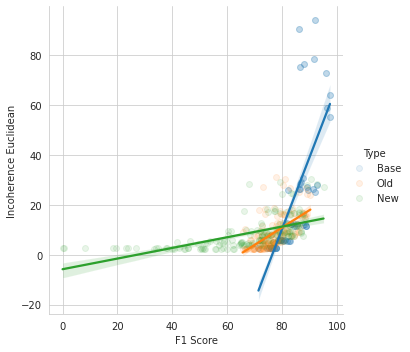

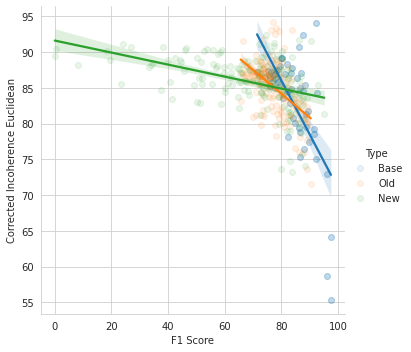

In [53]:
# g = sns.lmplot(x='#Classes', y='F1 Score', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='#Classes', y='Incoherence Euclidean', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='#Classes', y='Corrected Incoherence Euclidean', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Incoherence Euclidean', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Corrected Incoherence Euclidean', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='F1 Score', y='Incoherence Euclidean', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', col='#Classes', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='F1 Score', y='Corrected Incoherence Euclidean', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', col='#Classes', scatter_kws={'alpha': 0.1})
# _ = g.set(yscale='log')

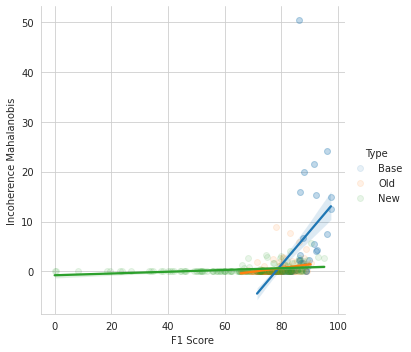

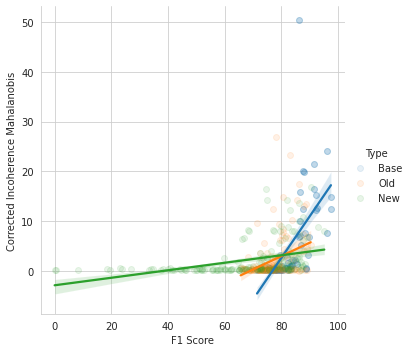

In [54]:
# g = sns.lmplot(x='#Classes', y='F1 Score', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='#Classes', y='Incoherence Mahalanobis', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='#Classes', y='Corrected Incoherence Mahalanobis', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Incoherence Mahalanobis', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Corrected Incoherence Mahalanobis', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='F1 Score', y='Incoherence Mahalanobis', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', col='#Classes', scatter_kws={'alpha': 0.1})
# g = sns.lmplot(x='F1 Score', y='Corrected Incoherence Mahalanobis', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', col='#Classes', scatter_kws={'alpha': 0.1})
# _ = g.set(yscale='log')

In [95]:
df_incoherence_incr

,Seed,Network,Approach,Batch Size,Patience,Out Features Size,Momentum,First Momentum,Increment,Episode,#Classes,F1 Score,Incoherence Euclidean,Incoherence Mahalanobis,Corrected Incoherence Euclidean,Corrected Incoherence Mahalanobis,Silhouette,Type
0,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,0.0,2.0,86.721557,75.286130,15.815666,75.286130,15.815666,0.146501,Base
1,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,0.0,2.0,86.721557,75.286130,15.815666,75.286130,15.815666,0.146501,Avg
2,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,1.0,4.0,80.468232,27.808742,2.783966,83.426226,8.351898,0.046412,Old
3,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,1.0,4.0,88.960761,27.871415,2.297548,83.614245,6.892643,0.048603,New
4,0.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,2.0,1.0,4.0,84.714497,27.840079,2.540757,83.520236,7.622271,0.047507,Avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,0.0,32.0,75.158735,2.816526,0.027658,87.312291,0.857412,-0.020059,Base
791,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,0.0,32.0,75.158735,2.816526,0.027658,87.312291,0.857412,-0.020059,Avg
792,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,1.0,40.0,71.471928,2.239754,0.017411,87.350395,0.679028,-0.029442,Old
793,10.0,Lopez17CNN,BiC,64.0,20.0,None,0.0,0.0,8.0,1.0,40.0,50.786798,2.213585,0.016468,86.329802,0.642270,-0.010458,New


In [149]:
def plot_scatter_features(x='F1 Score', y='Silhouette', hue='Type', col=None, data=None, data_filter=None, xlim=None, ylim=None):
    all_hue = list(sorted(data[hue].unique()))
    ncolors = 10 if len(all_hue) <= 10 else 20
    colors_dict = dict([(k, v) for k, v in zip(
        all_hue, [cm.get_cmap('tab%d' % ncolors)(i/ncolors) for i in range(ncolors)])])
    
    plot_data = data if data_filter is None else data[data_filter]
    hue_order = list(sorted(plot_data[hue].unique()))

    g = sns.lmplot(x=x, y=y, data=plot_data, hue=hue, hue_order=hue_order, col=col, scatter_kws={'alpha': 0.1},
                   palette=[colors_dict[k] for k in hue_order], legend=False)
    g.set(xlim=xlim, ylim=ylim)

    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=[
        Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=colors_dict[l], markersize=10) for l in hue_order])
    leg.get_frame().set_linewidth(0)
    
    plt.show()

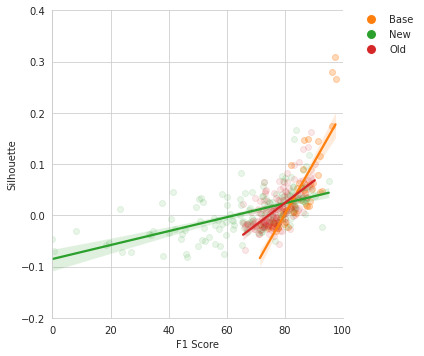

In [150]:
plot_scatter_features(data=df_incoherence_incr, data_filter=(df_incoherence_incr['Type'] != 'Avg'),
                      xlim=(0, 100), ylim=(-0.2, 0.4))

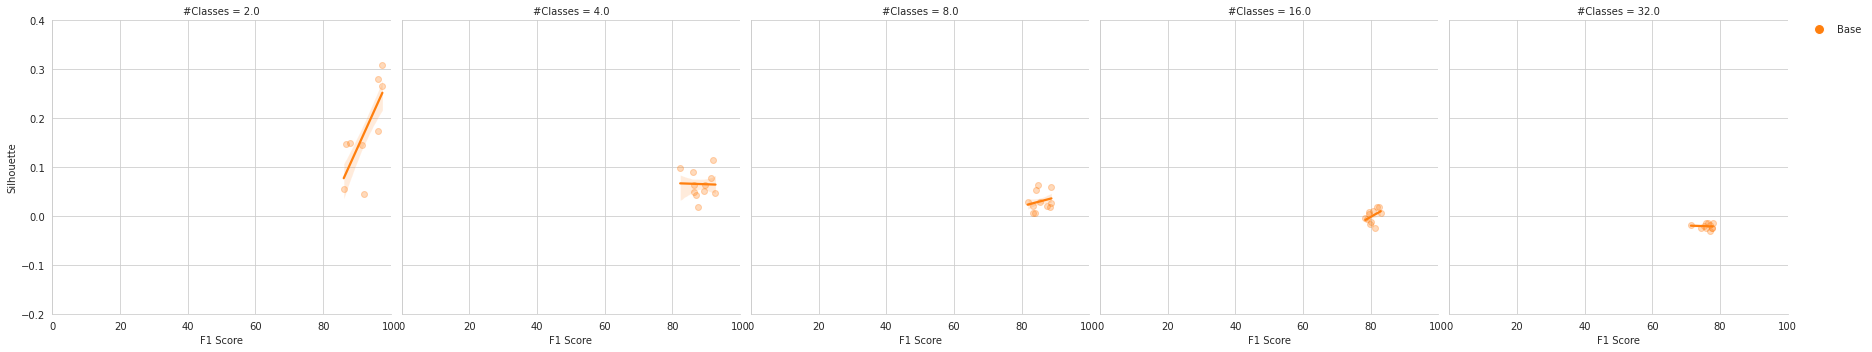

In [151]:
plot_scatter_features(data=df_incoherence_incr, data_filter=(df_incoherence_incr['Type'] == 'Base'), col='#Classes',
                      xlim=(0, 100), ylim=(-0.2, 0.4))

2.0


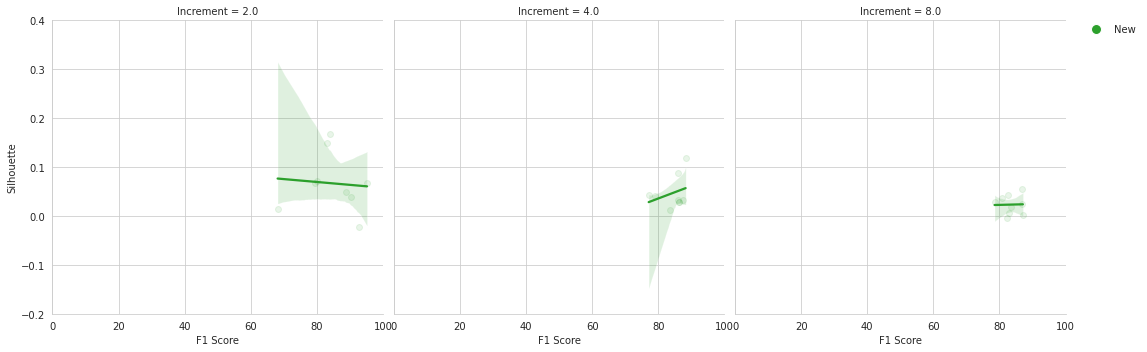

4.0


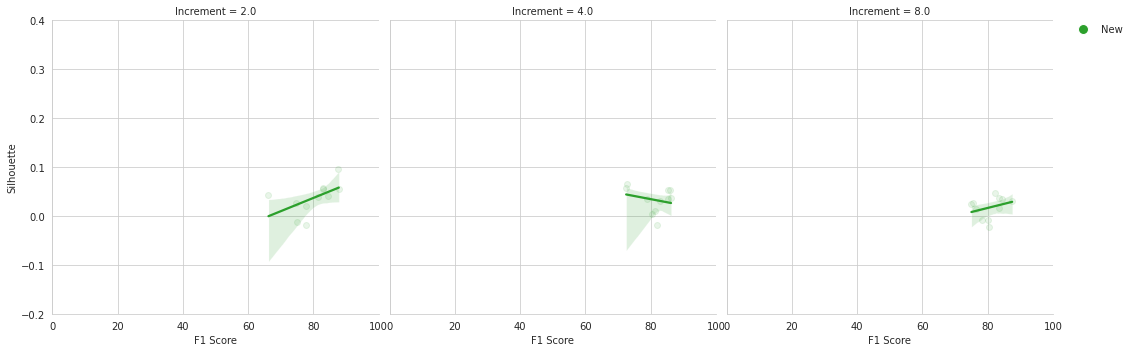

8.0


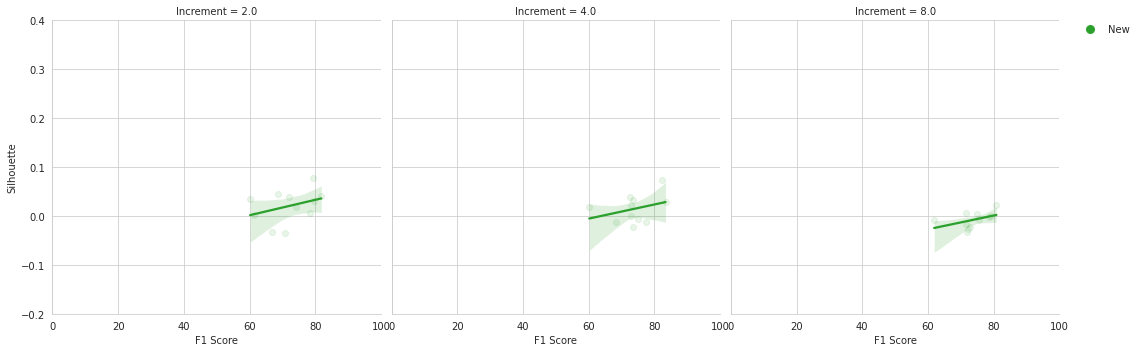

16.0


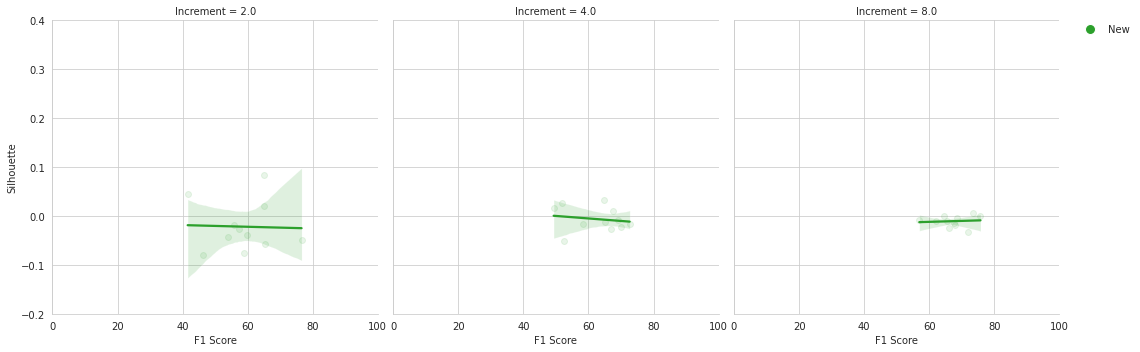

32.0


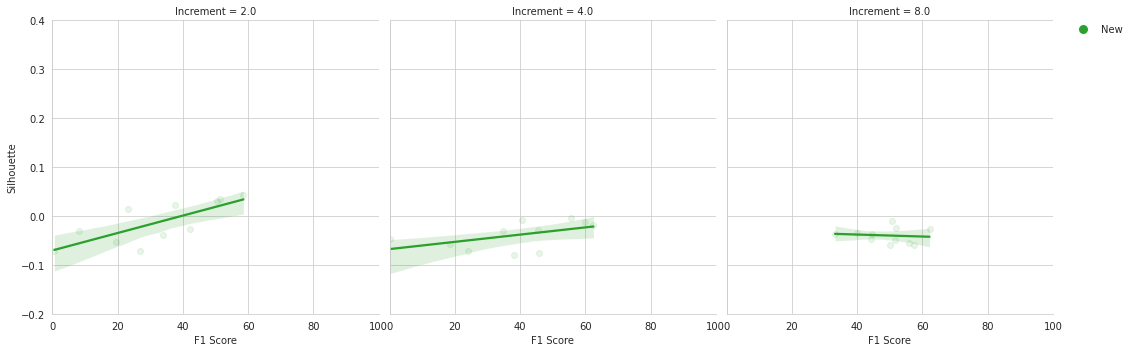

In [152]:
for c in df_incoherence_incr[(df_incoherence_incr['Type'] == 'Base')]['#Classes'].unique():
    print(c)
    plot_scatter_features(
        data=df_incoherence_incr,
        data_filter=(df_incoherence_incr['Type'] == 'New') &
        (df_incoherence_incr.apply(lambda x: x['#Classes']-x['Increment']*x['Episode'], axis=1) == c),
        col='Increment', xlim=(0, 100), ylim=(-0.2, 0.4))

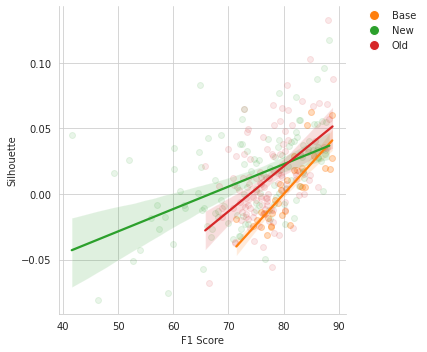

In [153]:
plot_scatter_features(data=df_incoherence_incr, data_filter= (df_incoherence_incr['Type'] != 'Avg') &
                      ~(df_incoherence_incr['#Classes'].isin([2, 4, 34, 36, 40])),)
#                       xlim=(0, 100), ylim=(-0.2, 0.4))

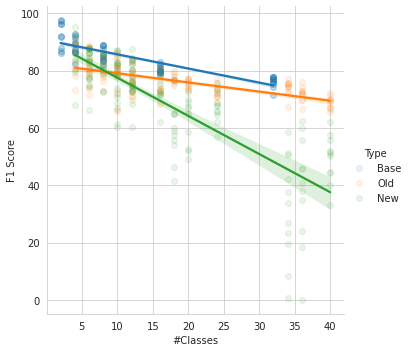

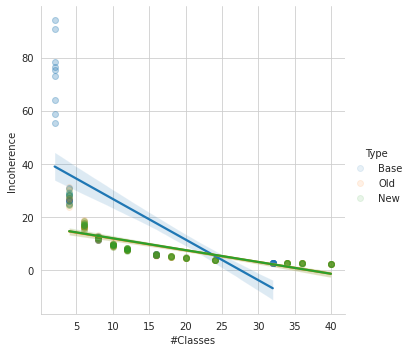

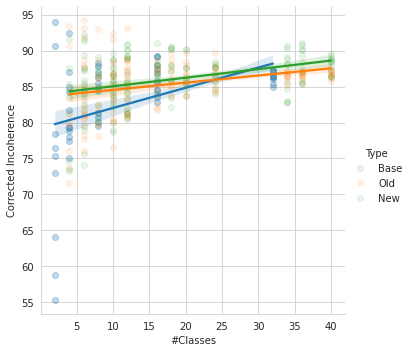

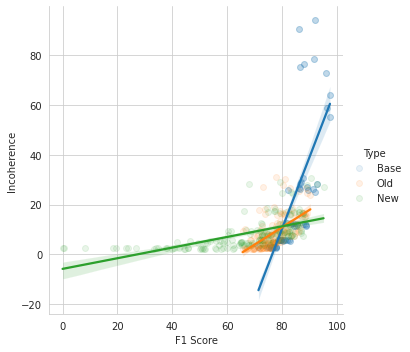

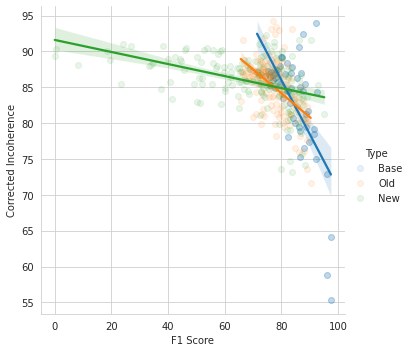

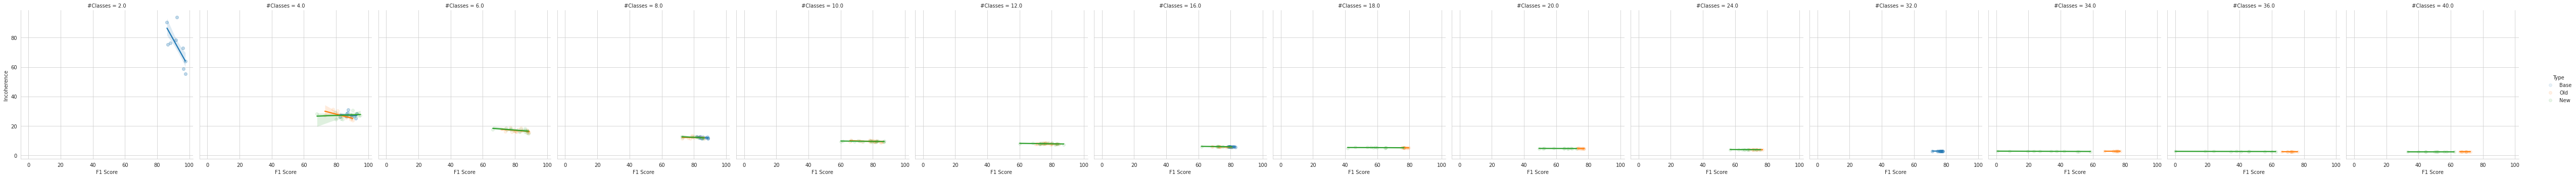

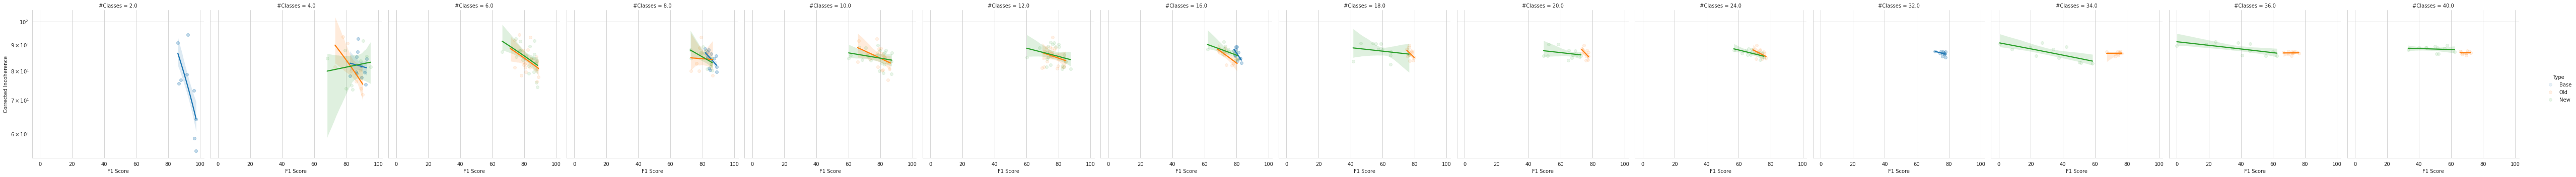

In [71]:
g = sns.lmplot(x='#Classes', y='F1 Score', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='#Classes', y='Incoherence', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='#Classes', y='Corrected Incoherence', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Incoherence', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Corrected Incoherence', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Incoherence', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', col='#Classes', scatter_kws={'alpha': 0.1})
g = sns.lmplot(x='F1 Score', y='Corrected Incoherence', data=df_incoherence_incr[df_incoherence_incr['Type'] != 'Avg'], hue='Type', col='#Classes', scatter_kws={'alpha': 0.1})
_ = g.set(yscale='log')

In [9]:
exp_name = 'scratch'
results_path = '../hf-project/results_UB/'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_incoherence_ub = load_data(df_filenames)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:29<00:00,  2.68s/it]


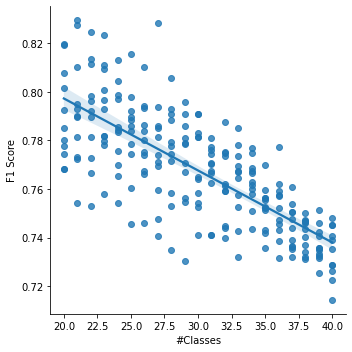

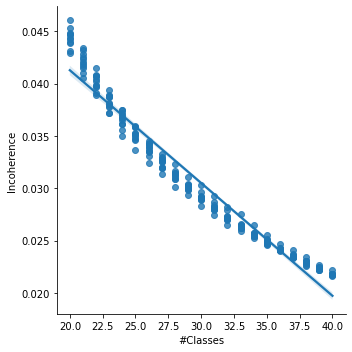

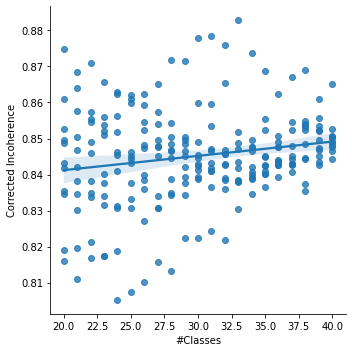

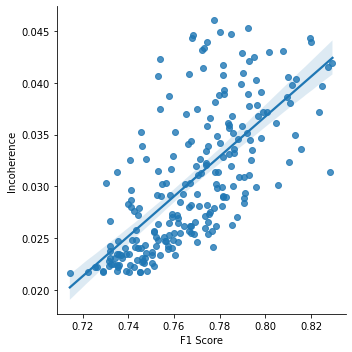

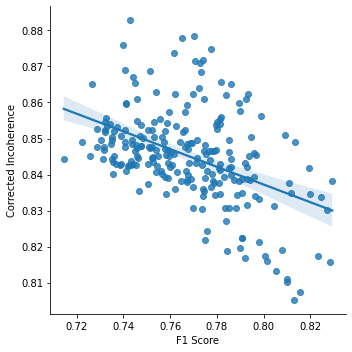

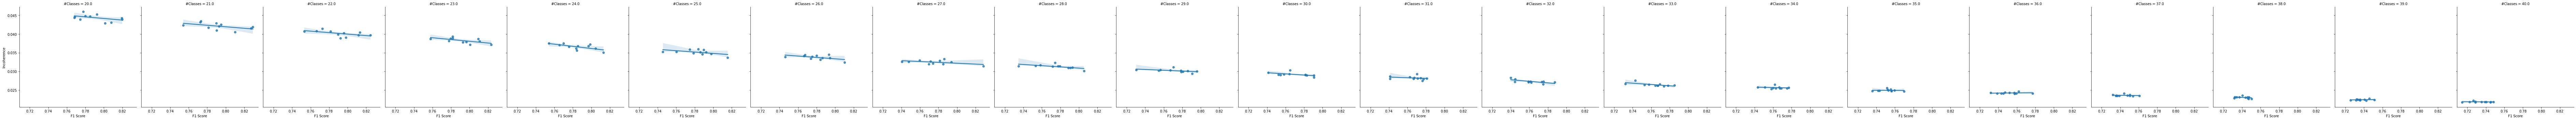

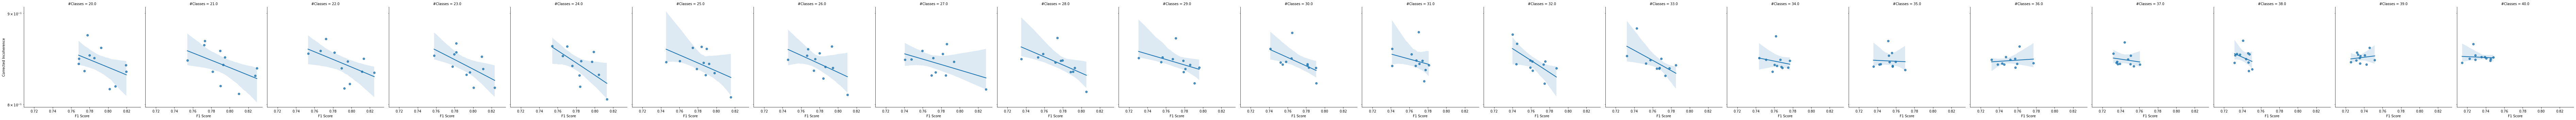

In [10]:
g = sns.lmplot(x='#Classes', y='F1 Score', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'])
g = sns.lmplot(x='#Classes', y='Incoherence', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'])
g = sns.lmplot(x='#Classes', y='Corrected Incoherence', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'])
g = sns.lmplot(x='F1 Score', y='Incoherence', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'])
g = sns.lmplot(x='F1 Score', y='Corrected Incoherence', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'])
g = sns.lmplot(x='F1 Score', y='Incoherence', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'], col='#Classes')
g = sns.lmplot(x='F1 Score', y='Corrected Incoherence', data=df_incoherence_ub[df_incoherence_ub['Type'] == 'Avg'], col='#Classes')
_ = g.set(yscale='log')

# Features Enhancement

## Goal 
Evaluate the impact of feature vector dimension and the backbone neural network nature on the NCM classifier.

Performance are evaluated in terms of F1 Score and Incoherence (also Corrected).

## Configuration

Multiple executions starting from *equal sized sets of base classes* and performing a *no increments*. 

**Number of Base Classes**: 20

**Approach**: iCaRL-FACIL

## Comment 

Looking at the F1 Score (Incoherence) the smaller the features vector size the higher (smaller) the value, viz. the better the classification capabilities.
Comparing the CNN and the CNN+RNN backbone neural networks, the latter shows an improvement of about 30% of F1 Score.

Take home messages:

- Using a **narrower features vector is beneficial**
- The **hybrid (CNN+RNN) neural network** backbone has a more powerful representation capability

In [59]:
import re

def get_stdout_list(df_filename):
    with open(df_filename) as fin:
        return [v.strip() for v in fin.readlines()]

def get_training_info(stdout_filenames):
    train_columns = ['Seed', 'Task', 'Epoch', 'Train Time', 'Validation Time', 'Validation Loss', 'TAw Accuracy',
                     'Learning Rate', 'Network', 'Out Features Size']
    timing_columns = ['Seed', 'Type', 'Task', 'Time', 'Num Samples', 'Network', 'Out Features Size']
    df_train = pd.DataFrame(columns=train_columns)
    df_timing = pd.DataFrame(columns=timing_columns)
    for filename in tqdm(stdout_filenames):
#         if not filename.endswith('stdout-1650811345.txt'):
            #print('Preprocessing %s' % filename)
        stdout_list = get_stdout_list(filename)

        # read args_dict
        with open(filename.replace('stdout', 'args')) as fin:
            try:
                args_dict = json.loads(fin.read())
            except:
                print(filename)
                input()

        row_train = {'Seed': int(args_dict['seed']), 'First Momentum': args_dict.get('first_momentum', 0), 'Base Momentum': args_dict.get('momentum', 0)}
        row_timing = {'Seed': int(args_dict['seed']), 'First Momentum': args_dict.get('first_momentum', 0), 'Base Momentum': args_dict.get('momentum', 0)}    
        
        row_train.update({'Network': args_dict['network'], 'Out Features Size': args_dict['out_features_size']})
        row_timing.update({'Network': args_dict['network'], 'Out Features Size': args_dict['out_features_size']})
        
        lr = float(args_dict['lr'])
        for line in stdout_list:
            line = re.sub(' +', ' ', line)
            if 'Task' in line:
                task = int(line.split(' ')[-1])
            if 'Epoch' in line:
                row_train.update({'Learning Rate': lr})
                row_train.update({'Task': task})
                line_s = line.split('|')
                try:
                    row_train.update({'Epoch': int(line_s[1].split(' ')[2].replace(',', ''))})
                except:
                    print(line)
                    input()
                row_train.update({'Train Time': float(line_s[1].split(' ')[3].split('=')[-1].replace('s', ''))})
                row_train.update({'Validation Loss': float(line_s[3].split(' ')[3].split('=')[-1].replace(',', ''))})
                row_train.update({'Validation Time': float(line_s[3].split(' ')[2].split('=')[-1].replace('s', ''))})
                row_train.update({'TAw Accuracy': float(line_s[3].split('=')[-1].replace('%', ''))})
                df_train = df_train.append(row_train, ignore_index=True)
                if 'lr' in line:
                    lr = float(line_s[4].split('=')[-1].replace(',', '.'))
            if 'Train Time' in line:
                for i in np.arange(3):
                    row_timing.update({'Task': task})
                    row_timing.update({'Type': line.split(' ')[3 + i].split('=')[0]})
                    row_timing.update({'Time': float(line.split(' ')[3 + i].split('=')[1][:-2])})
                    df_timing = df_timing.append(row_timing, ignore_index=True)
            if 'Test' in line:
                row_timing.update({'Num Samples': line.split(' ')[-2]})
                # row_timing.update({'Task': int(line.split(' ')[5])})
                row_timing.update({'Task': task})
                row_timing.update({'Type': 'Test'})
                row_timing.update({'Time': float(line.split('time=')[1].split(' ')[1][:-1])})
                df_timing = df_timing.append(row_timing, ignore_index=True)
                row_timing.update({'Num Samples': 'NaN'})

        # saving dataframe
        #path_index = filename.rfind('/')
        #df_train_filename = filename[:path_index] + '/results/df_train.parquet'
        #df_timing_filename = filename[:path_index] + '/results/df_timing.parquet'
        #df_train.to_parquet(df_train_filename)
        #df_timing.to_parquet(df_timing_filename)
    return df_train, df_timing


In [46]:
exp_name = 'scratch_features_enhancement'
#results_path = '../hf-project/results/'
results_path ='/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_featsenhance = load_data(df_filenames)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:04<00:00, 20.05it/s]


In [10]:
df_featsenhance

,Seed,Network,Approach,Batch Size,Patience,Out Features Size,Momentum,First Momentum,Increment,Episode,#Classes,F1 Score,Incoherence Euclidean,Incoherence Mahalanobis,Corrected Incoherence Euclidean,Corrected Incoherence Mahalanobis,Silhouette,Type
0,4.0,Lopez17CNN,iCaRL-FACIL,64.0,20.0,400.0,0.0,0.0,2.0,0.0,20.0,36.671914,0.0,0.0,0.0,0.0,0.0,Base
1,4.0,Lopez17CNN,iCaRL-FACIL,64.0,20.0,400.0,0.0,0.0,2.0,0.0,20.0,36.671914,0.0,0.0,0.0,0.0,0.0,Avg
2,4.0,Lopez17CNN,iCaRL-FACIL,64.0,20.0,400.0,0.0,0.0,2.0,0.0,20.0,36.671914,0.0,0.0,0.0,0.0,0.0,Base
3,4.0,Lopez17CNN,iCaRL-FACIL,64.0,20.0,400.0,0.0,0.0,2.0,0.0,20.0,36.671914,0.0,0.0,0.0,0.0,0.0,Avg
4,4.0,Lopez17CNN,iCaRL-FACIL,64.0,20.0,400.0,0.0,0.0,2.0,0.0,20.0,36.671914,0.0,0.0,0.0,0.0,0.0,Base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,4.0,Lopez17CNN,Scratch,64.0,20.0,200.0,0.0,0.0,2.0,0.0,20.0,78.442274,0.0,0.0,0.0,0.0,0.0,Avg
644,4.0,Lopez17CNNRNN,Scratch,64.0,20.0,200.0,0.0,0.0,2.0,0.0,20.0,78.564708,0.0,0.0,0.0,0.0,0.0,Base
645,4.0,Lopez17CNNRNN,Scratch,64.0,20.0,200.0,0.0,0.0,2.0,0.0,20.0,78.564708,0.0,0.0,0.0,0.0,0.0,Avg
646,1.0,Lopez17RNN,Scratch,64.0,20.0,400.0,0.0,0.0,2.0,0.0,20.0,83.773645,0.0,0.0,0.0,0.0,0.0,Base


In [458]:
print(df_featsenhance[df_featsenhance['Network']=='Lopez17CNNRNN']['Seed'].unique())
nets = ['Lopez17CNN', 'Lopez17CNNRNN', 'Lopez17RNN']
outs = [100,200,400]
for out in outs:
    for net in nets:
        #print(net,out)
        m = np.round(df_featsenhance[(df_featsenhance['Seed']!=0) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch') & (df_featsenhance['Type']!='Base')]['F1 Score'].mean(),2)
        s = np.round(df_featsenhance[(df_featsenhance['Seed']!=0) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch') & (df_featsenhance['Type']!='Base')]['F1 Score'].std(),2)
        print(str(m)+'($pm$'+str(s)+')')
        #print(df_featsenhance[(df_featsenhance['Seed']!=11) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch')]['F1 Score'])
        #print(df_featsenhance[(df_featsenhance['Seed']!=0) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch') & (df_featsenhance['Type']!='Avg')]['F1 Score'])
        #input()


[ 0.  1.  2.  3.  4.  8.  9.  7.  6. 10.  5.]
79.42($pm$2.05)
78.71($pm$1.59)
79.66($pm$2.54)
79.66($pm$1.64)
78.83($pm$1.65)
79.85($pm$2.5)
80.67($pm$1.96)
78.97($pm$1.71)
80.12($pm$2.66)


In [47]:
print(df_featsenhance[df_featsenhance['Network']=='Lopez17CNN']['Seed'].unique())
print(df_featsenhance[df_featsenhance['Network']=='Lopez17CNNRNN']['Seed'].unique())
print(df_featsenhance[df_featsenhance['Network']=='Lopez17RNN']['Seed'].unique())
nets = ['Lopez17CNN', 'Lopez17CNNRNN', 'Lopez17RNN']
outs = [100,200,400]
for out in outs:
    for net in nets:
        print(net,out)
        m = np.round(df_featsenhance[(df_featsenhance['Seed']!=0) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch') & (df_featsenhance['Type']!='Base')]['F1 Score'].mean(),2)
        s = np.round(df_featsenhance[(df_featsenhance['Seed']!=0) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch') & (df_featsenhance['Type']!='Base')]['F1 Score'].std(),2)
        print(str(m)+'($pm$'+str(s)+')')
        #print(df_featsenhance[(df_featsenhance['Seed']!=11) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch')]['F1 Score'])
        #print(df_featsenhance[(df_featsenhance['Seed']!=0) & (df_featsenhance['Network']==net) & (df_featsenhance['Out Features Size']==out) & (df_featsenhance['Approach']=='Scratch') & (df_featsenhance['Type']!='Avg')]['F1 Score'])
        #input()

[ 6.  7. 10.  8.  5.  9.  4.  1.  3.  2.]
[ 8.  9.  7.  6. 10.  5.  1.  3.  2.  4.]
[ 6.  5.  7.  9.  8. 10.  1.  2.  3.  4.]
Lopez17CNN 100
80.0($pm$1.75)
Lopez17CNNRNN 100
79.02($pm$1.46)
Lopez17RNN 100
80.74($pm$1.55)
Lopez17CNN 200
80.19($pm$1.41)
Lopez17CNNRNN 200
79.07($pm$1.54)
Lopez17RNN 200
81.14($pm$1.48)
Lopez17CNN 400
81.19($pm$1.73)
Lopez17CNNRNN 400
79.44($pm$1.33)
Lopez17RNN 400
81.45($pm$1.75)


In [60]:
df_filenames_time = glob('%s/*%s*/**/*stdout*' % (results_path, exp_name), recursive=True)
df_tr, df_tm = get_training_info(df_filenames_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [04:14<00:00,  2.70s/it]


In [66]:
print(df_tr.columns)
print(df_tr['Task'].unique())

Index(['Seed', 'Task', 'Epoch', 'Train Time', 'Validation Time',
       'Validation Loss', 'TAw Accuracy', 'Learning Rate', 'Network',
       'Out Features Size', 'Base Momentum', 'First Momentum'],
      dtype='object')
[0]


In [83]:
med_time=df_tr.groupby(['Seed', 'Network', 'Out Features Size'])['Train Time'].median().reset_index()
max_epoch=df_tr.groupby(['Seed', 'Network', 'Out Features Size'])['Epoch'].max().reset_index()

print(med_time.groupby(['Network', 'Out Features Size'])['Train Time'].mean())
print(max_epoch.groupby(['Network', 'Out Features Size'])['Epoch'].mean())

compl = med_time[['Network', 'Out Features Size']]
compl.loc[:, 'Train Time'] = med_time['Train Time']
compl.loc[:, 'Epoch'] = max_epoch['Epoch']

compl.loc[:, 'Total Time'] = compl.apply(lambda x: x['Train Time'] * x['Epoch'], axis=1)

compl.groupby(['Network', 'Out Features Size'])['Total Time'].mean().to_latex()

Network        Out Features Size
Lopez17CNN     100                  14.12830
               200                  15.88335
               400                  19.45770
Lopez17CNNRNN  100                   9.44725
               200                   9.61565
               400                   9.64700
Lopez17RNN     100                   7.99080
               200                   8.11630
               400                   8.41920
Name: Train Time, dtype: float64
Network        Out Features Size
Lopez17CNN     100                  185.3
               200                  174.6
               400                  174.8
Lopez17CNNRNN  100                  199.5
               200                  200.0
               400                  199.9
Lopez17RNN     100                  200.0
               200                  200.0
               400                  200.0
Name: Epoch, dtype: float64


'\\begin{tabular}{llr}\n\\toprule\n           &     &  Total Time \\\\\nNetwork & Out Features Size &             \\\\\n\\midrule\nLopez17CNN & 100 &   2613.8383 \\\\\n           & 200 &   2767.5130 \\\\\n           & 400 &   3400.7781 \\\\\nLopez17CNNRNN & 100 &   1884.4020 \\\\\n           & 200 &   1923.1300 \\\\\n           & 400 &   1928.2869 \\\\\nLopez17RNN & 100 &   1598.1600 \\\\\n           & 200 &   1623.2600 \\\\\n           & 400 &   1683.8400 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
# fig, ax = plt.subplots()
_ = sns.catplot(x='Network', y='F1 Score', data=df_featsenhance[(df_featsenhance['Episode'] == 0) & (df_featsenhance['Type'] == 'Base')], hue='Out Features Size', col='Approach', kind='box')
# fig, ax = plt.subplots()
# _ = sns.catplot(x='Network', y='Incoherence', data=df_featsenhance[(df_featsenhance['Episode'] == 0) & (df_featsenhance['Type'] == 'Base')], hue='Out Features Size', col='Approach', kind='box')
# fig, ax = plt.subplots()
# _ = sns.catplot(x='Network', y='Corrected Incoherence', data=df_featsenhance[(df_featsenhance['Episode'] == 0) & (df_featsenhance['Type'] == 'Base')], hue='Out Features Size', col='Approach', kind='box')
# _ = sns.catplot(x='Network', y='Silhouette', data=df_featsenhance[(df_featsenhance['Episode'] == 0) & (df_featsenhance['Type'] == 'Base')], hue='Out Features Size', col='Approach', kind='box')
plt.savefig('FeatureExtractorImpact.pdf', bbox_inches='tight')

# Finetuning Momentum

## Goal 
Evaluate the impact of training a base model with different values of momentum.

In detail, when a base model is trained the momentum of SGD is varied within the range 0-0.9 with step 0.1. The incremental training by finetuning is obtained considering a first momentum of 0.9.

## Configuration

Multiple executions starting from *equal sized sets of base classes* and performing a *single increment*. 

**Number of Base Classes**: 20

**Size of Increment**: 5

**Approach**: Finetuning

## Comment 

The first, clear, outcome is the strong dipendence of the Catastrophic Forgetting to the selected momentum at the base model training.

In detail, the increasing the momentum at the first task training, the lower the catastrophic forgetting, also positively impacting the performane on new classes for momentum <= 0.8.
The best trade-off seems to be a momentum of 0.8, with limited forgetting and lower intransigence.

This outcome is possibly due to the lower number of epochs (160 vs 180) when the momentum is higher at the base model train.

Take home message:

- Training a base model with momentum **mitigates the catastrophic forgetting**

In [63]:
exp_name = 'finetuning_momentum'
results_path = '../hf-project/results/'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_stdout_filenames = glob('%s/*%s*/**/*stdout*' % (results_path, exp_name), recursive=True)

if os.path.exists('./df_momentum.parquet'):
    df_momentum = pd.read_parquet('./df_momentum.parquet')
else:
    df_momentum = load_data(df_filenames)
    df_momentum.to_parquet('./df_momentum.parquet')

if os.path.exists('./df_mom_tr.parquet') and os.path.exists('./df_mom_ti.parquet'):
    df_mom_tr, df_mom_ti = pd.read_parquet('./df_mom_tr.parquet'), pd.read_parquet('./df_mom_ti.parquet')
else:
    df_mom_tr, df_mom_ti = get_training_info(df_stdout_filenames)
    df_mom_tr['First Momentum'] = df_mom_tr['First Momentum'].astype(str)
    df_mom_ti['First Momentum'] = df_mom_ti['First Momentum'].astype(str)
    df_mom_tr.to_parquet('./df_mom_tr.parquet')
    df_mom_ti.to_parquet('./df_mom_ti.parquet')


In [154]:
exp_name = 'finetun_momentum_lixuan'
results_path = '../hf-project/results/'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_stdout_filenames = glob('%s/*%s*/**/*stdout*' % (results_path, exp_name), recursive=True)

df_momentum = load_data(df_filenames)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:35<00:00,  5.46it/s]


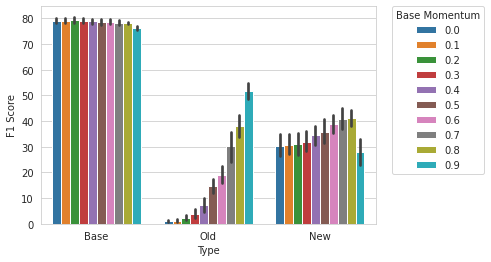

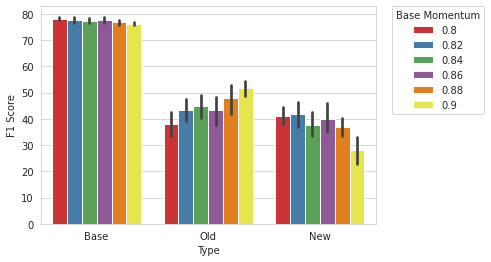

In [64]:
fig, ax = plt.subplots()
_ = sns.barplot(x='Type', y='F1 Score', palette='tab10',
                data=df_momentum[(df_momentum['Type'] != 'Avg') & (df_momentum['Momentum'] == .9) & ((df_momentum['First Momentum'] <= .8) | (df_momentum['First Momentum'] >= .9))], hue='First Momentum', ax=ax)
_ = plt.legend(title='Base Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
_ = sns.barplot(x='Type', y='F1 Score', palette='Set1',
                data=df_momentum[(df_momentum['Type'] != 'Avg') & (df_momentum['Momentum'] == .9) & (df_momentum['First Momentum'] >= .8) & (df_momentum['First Momentum'] <= .9)], hue='First Momentum', ax=ax)
_ = plt.legend(title='Base Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


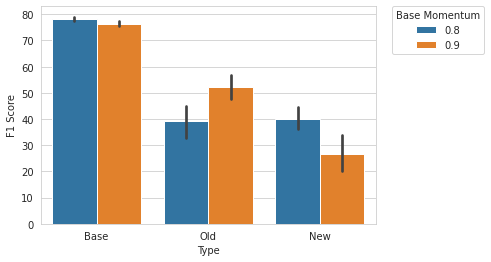

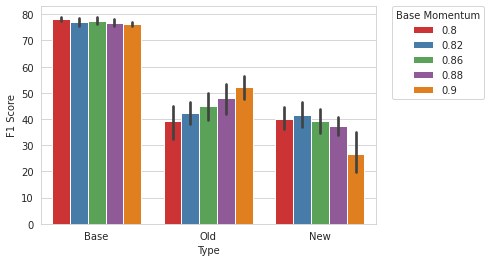

In [155]:
fig, ax = plt.subplots()
_ = sns.barplot(x='Type', y='F1 Score', palette='tab10',
                data=df_momentum[(df_momentum['Type'] != 'Avg') & (df_momentum['Momentum'] == .9) & ((df_momentum['First Momentum'] <= .8) | (df_momentum['First Momentum'] >= .9))], hue='First Momentum', ax=ax)
_ = plt.legend(title='Base Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig, ax = plt.subplots()
_ = sns.barplot(x='Type', y='F1 Score', palette='Set1',
                data=df_momentum[(df_momentum['Type'] != 'Avg') & (df_momentum['Momentum'] == .9) & (df_momentum['First Momentum'] >= .8) & (df_momentum['First Momentum'] <= .9)], hue='First Momentum', ax=ax)
_ = plt.legend(title='Base Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


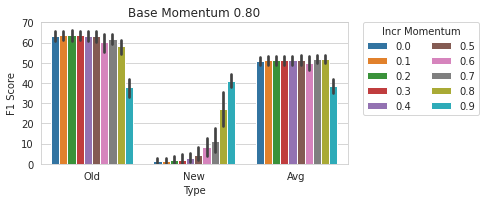

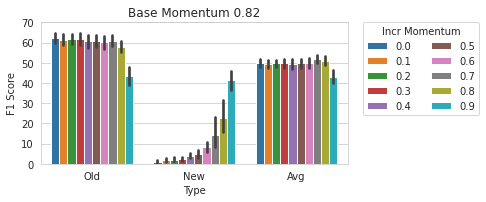

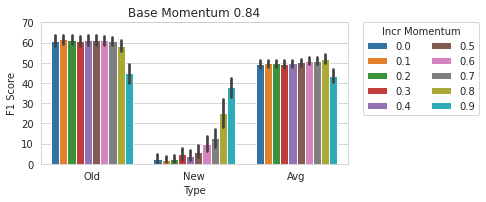

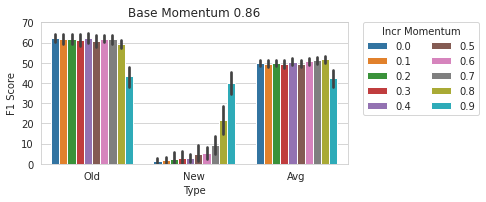

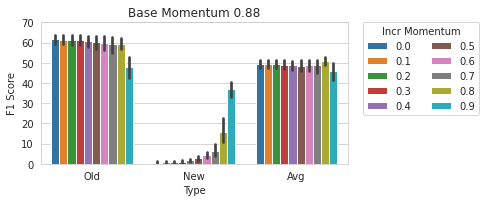

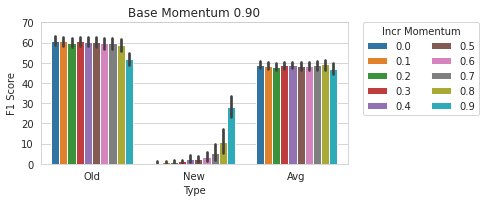

In [65]:
base_momentum = sorted(df_momentum['First Momentum'].unique())[-6:]
for bm in base_momentum:
    fig, ax = plt.subplots(figsize=(5.5,2.6))
    _ = sns.barplot(x='Type', y='F1 Score',
                    data=df_momentum[(df_momentum['Type'] != 'Base') & (df_momentum['First Momentum'] == bm) & (df_momentum['Episode'] == 1)], hue='Momentum', ax=ax)
    _ = plt.legend(title='Incr Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
    _ = plt.title("Base Momentum %.2f" %  bm)
    _ = plt.ylim([0,70])

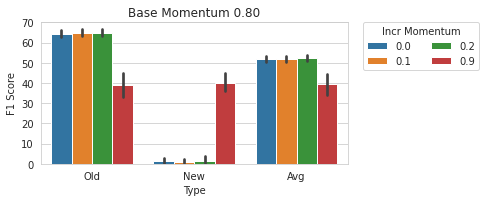

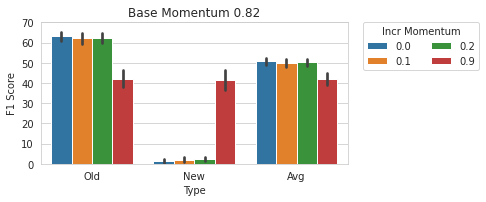

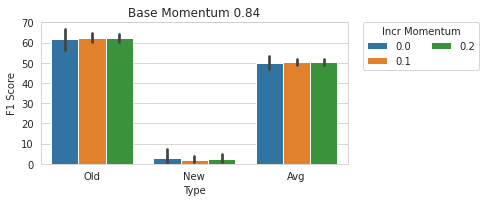

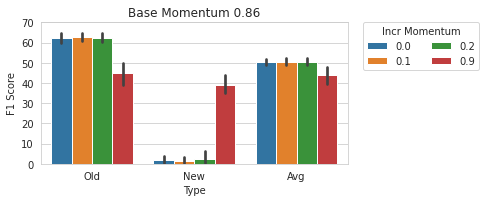

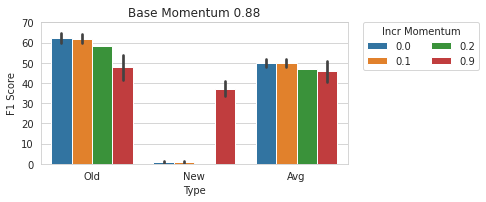

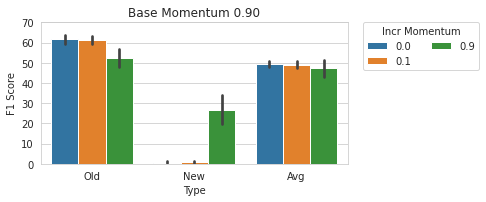

In [157]:
base_momentum = sorted(df_momentum['First Momentum'].unique())[-6:]
for bm in base_momentum:
    fig, ax = plt.subplots(figsize=(5.5,2.6))
    _ = sns.barplot(x='Type', y='F1 Score',
                    data=df_momentum[(df_momentum['Type'] != 'Base') & (df_momentum['First Momentum'] == bm) & (df_momentum['Episode'] == 1)], hue='Momentum', ax=ax)
    _ = plt.legend(title='Incr Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
    _ = plt.title("Base Momentum %.2f" %  bm)
    _ = plt.ylim([0,70])

In [68]:
'''
exp_name = 'finetuning_momentum'
results_path = '../hf-project/results/'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_stdout_filenames = glob('%s/*%s*/**/*stdout*' % (results_path, exp_name), recursive=True)
#df_momentum = load_data(df_filenames)
df_mom_tr, df_mom_ti = get_training_info(df_stdout_filenames)
df_mom_tr['First Momentum'] = df_mom_tr['First Momentum'].astype(str)
df_mom_ti['First Momentum'] = df_mom_ti['First Momentum'].astype(str)
'''
exp_name = 'finetuning_momentum'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_stdout_filenames = glob('%s/*%s*/**/*stdout*' % (results_path, exp_name), recursive=True)
#print(df_stdout_filenames)
#df_momentum = load_data(df_filenames)
df_mom_tr, df_mom_ti = get_training_info(df_stdout_filenames)
df_mom_tr['First Momentum'] = df_mom_tr['First Momentum'].astype(str)
df_mom_ti['First Momentum'] = df_mom_ti['First Momentum'].astype(str)

 22%|██████████████████████▌                                                                               | 170/767 [06:41<25:18,  2.54s/it]

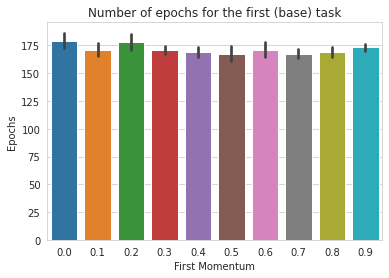

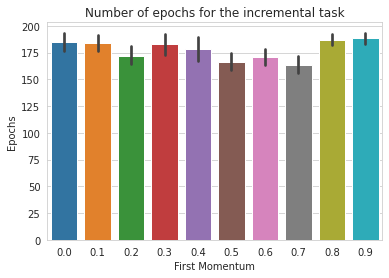

In [77]:
fig, ax = plt.subplots()
_ = sns.barplot(x='First Momentum', y='Epochs',
                data=df_max_epochs[(df_max_epochs['Task'] == 0) & (~df_max_epochs['First Momentum'].isin([str(v) for v in np.arange(0.82, 0.88, 0.02)]))], ax=ax)
_ = ax.set_title('Number of epochs for the first (base) task')

fig, ax = plt.subplots()
_ = sns.barplot(x='First Momentum', y='Epochs',
                data=df_max_epochs[(df_max_epochs['Task'] == 1) & (~df_max_epochs['First Momentum'].isin([str(v) for v in np.arange(0.82, 0.88, 0.02)]))], ax=ax)
_ = ax.set_title('Number of epochs for the incremental task')

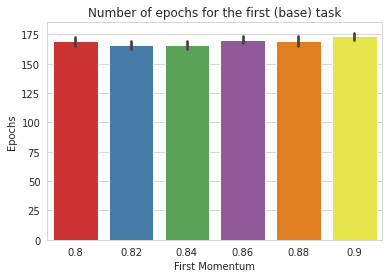

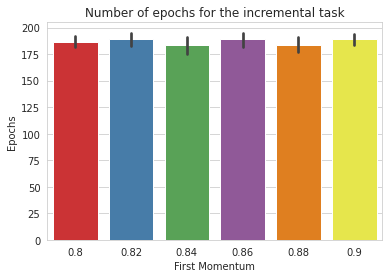

In [85]:
fig, ax = plt.subplots()
_ = sns.barplot(x='First Momentum', y='Epochs', palette='Set1',
                data=df_max_epochs[(df_max_epochs['Task'] == 0) & (df_max_epochs['First Momentum'].isin([str(v) for v in base_momentum]))], ax=ax)
_ = ax.set_title('Number of epochs for the first (base) task')

fig, ax = plt.subplots()
_ = sns.barplot(x='First Momentum', y='Epochs', palette='Set1',
                data=df_max_epochs[(df_max_epochs['Task'] == 1) & (df_max_epochs['First Momentum'].isin([str(v) for v in base_momentum]))], ax=ax)
_ = ax.set_title('Number of epochs for the incremental task')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:01<00:00, 208.54it/s]


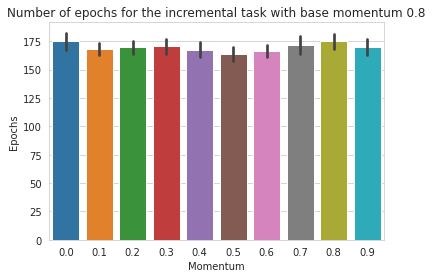

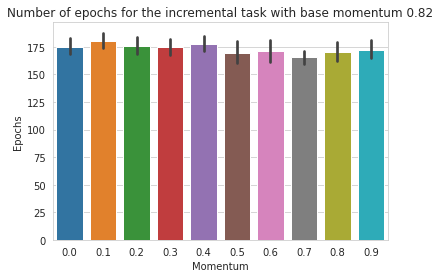

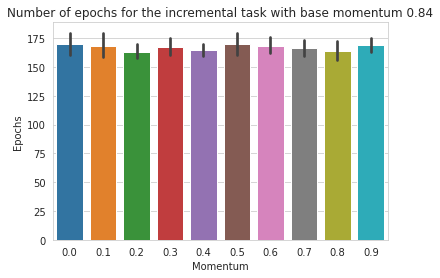

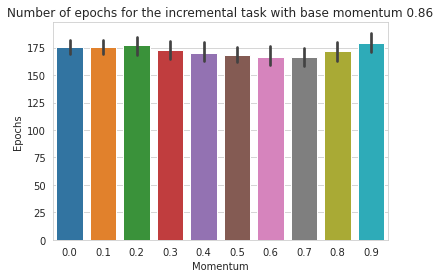

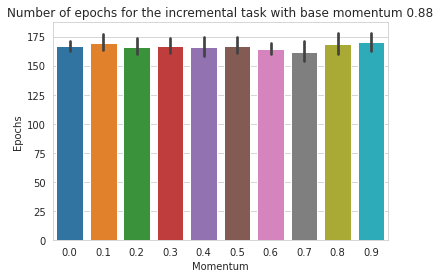

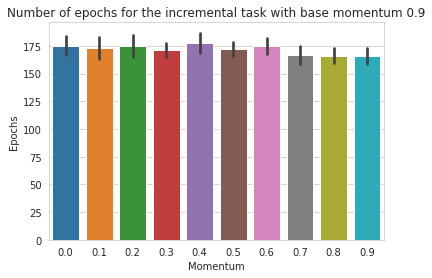

In [87]:
base_momentum = ['0.8', '0.82', '0.84', '0.86', '0.88', '0.9']
for bm in base_momentum:
    df_max_epochs2 = pd.DataFrame()
    df_mom_tr_filter = df_mom_tr[df_mom_tr['First Momentum']==bm]
    #print(df_mom_tr_filter)
    for g, d in tqdm(df_mom_tr_filter.groupby(['Seed', 'Task', 'Base Momentum'])):
        row = {'Seed': g[0], 'Task': g[1], 'Momentum': g[2]}
        max_epoch = d['Epoch'].max()
        train_time = d['Train Time'].sum()
        row.update({'Epochs': max_epoch, 'Total Train Time': train_time})
        df_max_epochs2 = df_max_epochs2.append(row, ignore_index=True)
    #print(df_max_epochs2)
    #input()
    #fig, ax = plt.subplots()
    #_ = sns.barplot(x='Momentum', y='Epochs', data=df_max_epochs2[df_max_epochs2['Task'] == 0], ax=ax)
    #_ = ax.set_title('Number of epochs for the first (base) task with base momentum %s' % bm)

    fig, ax = plt.subplots()
    _ = sns.barplot(x='Momentum', y='Epochs', data=df_max_epochs2[df_max_epochs2['Task'] == 1], ax=ax)
    _ = ax.set_title('Number of epochs for the incremental task with base momentum %s' % bm) 

In [ ]:
plt.close('all')

In [1]:
fig, ax = plt.subplots()
_ = sns.barplot(x='First Momentum', y='Total Train Time', data=df_max_epochs[df_max_epochs['Task'] == 0])
_ = ax.set_title('Total train time for the first (base) task')

fig, ax = plt.subplots()
_ = sns.barplot(x='First Momentum', y='Total Train Time', data=df_max_epochs[df_max_epochs['Task'] == 1])
_ = ax.set_title('Total train time for the incremental task')

NameError: name 'plt' is not defined

KeyboardInterrupt: 

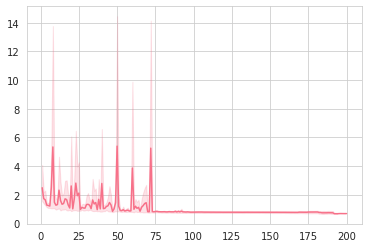

In [67]:
df_mom_tr.to_parquet('/media/nas/dataset/xai/material_facil/df_mom_tr.parquet')
base_momentum = ['0.8', '0.82', '0.84', '0.86', '0.88', '0.9']
for bm in base_momentum:
    df_max_epochs2 = pd.DataFrame()
    df_mom_tr_filter = df_mom_tr[df_mom_tr['First Momentum']==bm]
    #print(df_mom_tr_filter)
    for g, d in tqdm(df_mom_tr_filter.groupby(['Seed', 'Task', 'Base Momentum'])):
        row = {'Seed': g[0], 'Task': g[1], 'Momentum': g[2]}
        max_epoch = d['Epoch'].max()
        train_time = d['Train Time'].sum()
        row.update({'Epochs': max_epoch, 'Total Train Time': train_time})
        df_max_epochs2 = df_max_epochs2.append(row, ignore_index=True)
    #print(df_max_epochs2)
    #input()
    #fig, ax = plt.subplots()
    #_ = sns.barplot(x='Momentum', y='Epochs', data=df_max_epochs2[df_max_epochs2['Task'] == 0], ax=ax)
    #_ = ax.set_title('Number of epochs for the first (base) task with base momentum %s' % bm)

fig, ax = plt.subplots()
_ = sns.lineplot(x='Epoch', y='Validation Loss', data=df_mom_tr[df_mom_tr['Task'] == 1], hue='First Momentum',
                 hue_order=sorted(df_mom_tr[df_mom_tr['Task'] == 1]['First Momentum'].unique()), ax=ax)
_ = plt.legend(title='Base Momentum', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = ax.set_yscale('log')
_ = ax.set_ylim(top=.5)
_ = ax.set_xlim(left=150)
_ = ax.set_title('Validation Loss for the incremental task')

In [154]:
exp_name = 'campaign5_base20_incr20'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/'
df_stdout_filenames = glob('%s/*%s*/*stdout*' % (results_path, exp_name), recursive=True)
df_tr, df_ti = get_training_info(df_stdout_filenames)

exp_name = 'mirage_generic_scratch'
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results_UB/'
df_stdout_filenames = glob('%s/%s/*stdout*' % (results_path, exp_name), recursive=True)
df_tr_scratch, df_ti_scratch = get_training_info(df_stdout_filenames)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:58<00:00, 10.73s/it]


In [487]:
ord_list = ['scratch','_', 'chen21','lucir', 'icarlp', 'ssil', '_', 'bic', 'wu22', 'icarl', 'ewc', 'eeil', 'il2m']
#ord_list2 = ['scratch', 'chen21','lucir', 'icarlp', 'ssil', 'bic', 'wu22', 'icarl', 'ewc', 'eeil', 'il2m']

def plot_train_time(df_t1_scratch, df_ti, scratch_task, appr_task, type, nclasses):

    if type=='all':
        fig, ax = plt.subplots(figsize=(12,5))
        dft1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='Test')]
        dft1_scratch = df_ti_scratch[(df_ti_scratch['Task']==scratch_task) & (df_ti_scratch['Type']!='Test')]
        df1_scratch = dft1_scratch.groupby(['Approach','Seed'])['Time'].sum().reset_index()
        df1 = dft1.groupby(['Approach','Seed'])['Time'].sum().reset_index()
        df = pd.concat([df1, df1_scratch])
        df['Time'] = df['Time']. div(nclasses). round(2)
        bars = sns.barplot(x='Approach', y='Time' , data=df, ax=ax, order=ord_list)
        bars.legend(ax.patches, ord_list, title='Approach', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1, ncol=1, fontsize=12)
        miny, maxy = ax.get_ylim()
        plt.xticks([])
        patches=[]
        for i,b in enumerate(ax.patches):
            if ord_list[i]=='_': 
                x,y = b.get_xy()
                plt.vlines(x = x+b.get_width()/2, ymin = 0, ymax = maxy, color = 'gray', linewidth=1.5, linestyle='dashed')
        plt.tight_layout()

    elif type=='stacked':
        df1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']!='Test')]
        df1_scratch = df_ti_scratch[(df_ti_scratch['Task']==scratch_task) & (df_ti_scratch['Type']!='Test')]        
        df = pd.concat([df1, df1_scratch])
        df = df.groupby(['Approach','Type'])['Time'].mean().reset_index()
        approach = df[df['Type']=='pre_train']['Approach']
        post_train = df[df['Type']=='post_train']['Time']
        train = df[df['Type']=='train']['Time']
        pre_train = df[df['Type']=='pre_train']['Time']
        fig, ax = plt.subplots()
        df = pd.DataFrame({'Pre':pre_train.values,'Post':post_train.values,'Train':train.values}, index=approach.values)
        ax.set_yscale('log')
        ax.set_title('Execution Time (Stacked)')
        ax.set_ylabel('Time [s]')
        df.plot.bar(stacked=True, ax=ax)   
    else:
        fig, ax = plt.subplots(figsize=(6.4, 4.8))
        df1 = df_ti[(df_ti['Task']==appr_task) & (df_ti['Type']==type)]
        df1_scratch = df_ti_scratch[(df_ti_scratch['Task']==scratch_task) & (df_ti_scratch['Type']==type)]
        df = pd.concat([df1, df1_scratch])
        df['Time'] = df['Time']. div(nclasses). round(2)
        bars = sns.barplot(x='Approach', y='Time' , data=df, ax=ax, order=ord_list)
        bars.legend(ax.patches, ord_list, title='Approach', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1, ncol=1, fontsize=12)
        miny, maxy = ax.get_ylim()
        plt.xticks([])
        ax.set_ylabel('Time [s]')
        patches=[]
        for i,b in enumerate(ax.patches):
            if ord_list[i]=='_': 
                x,y = b.get_xy()
                plt.vlines(x = x+b.get_width()/2, ymin = 0, ymax = maxy, color = 'gray', linewidth=1.5, linestyle='dashed')

/media/nas/datasets/xai/material_facil/facil_venv/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f2f8fe5df10> has a label of '_' which cannot be automatically added to the legend.
/media/nas/datasets/xai/material_facil/facil_venv/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: The handle <matplotlib.patches.Rectangle object at 0x7f2f8fbea3d0> has a label of '_' which cannot be automatically added to the legend.


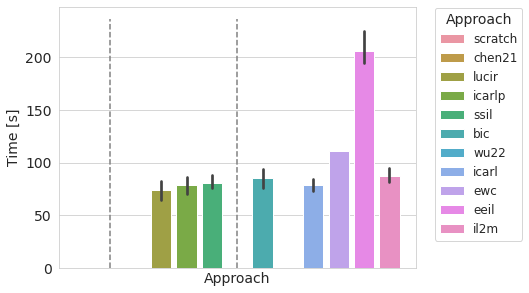

In [489]:
scratch_task = 20
appr_task = 1
nclasses = 1
group = '' #qui non c'è
type = 'post_train'
plot_train_time(df_ti_scratch, df_ti, scratch_task, appr_task, type, nclasses)

In [490]:
#filter data and create df for plot
metric = 'F1 Score Drop'
mean_new, mean_old, std_new, std_old = [[] for _ in range(4)]
type='New'
for e in np.unique(df[df['Type']==type]['Episode'].values):
    mean_new.append(df[(df['Episode']==e) & (df['Type']==type)][metric].mean())
    std_new.append(df[(df['Episode']==e) & (df['Type']==type)][metric].std())
type='Old'
for e in np.unique(df[df['Type']==type]['Episode'].values):
    mean_old.append(df[(df['Episode']==e) & (df['Type']==type)][metric].mean())
    std_old.append(df[(df['Episode']==e) & (df['Type']==type)][metric].std())
    
df_lst = pd.DataFrame(
    {'mean_new': mean_new,
     'mean_old': mean_old,
     'std_new': std_new,
     'std_old': std_old
    })

In [491]:
#load data
approach = 'bic'
exp_name = 'mirage_generic_%s_campaign5_base20_incr5_stop5' % approach
results_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results'
analysis = 'per_class_metrics'
df_filenames = glob('%s/*%s*/**/*%s.parquet' % (results_path, exp_name, analysis), recursive=True)
df_filenames.extend(glob('%s_UB/**/*%s.parquet' % (results_path, analysis), recursive=True))
df = load_data(df_filenames, compute_drops=True)

 18%|██████████████████████████████▋                                                                                                                                       | 27/146 [00:04<00:08, 14.30it/s]/media/nas/datasets/xai/material_facil/facil_venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/media/nas/datasets/xai/material_facil/facil_venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:09<00:00, 15.21it/s]


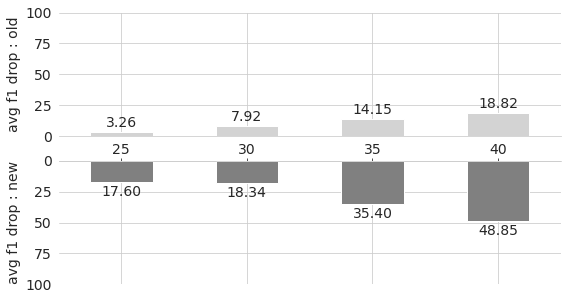

In [496]:
import matplotlib as mpl
# https://stackoverflow.com/questions/6615002/given-an-rgb-value-how-do-i-create-a-tint-or-shade/6615053
# For tints, calculate (255 - previous value), 
# multiply that by 1/4, 1/2, 3/4, etc. (the greater the factor, the lighter the tint),
# and add that to the previous value (assuming each.component is a 8-bit integer).
def make_lighter(rgba_color, weight=0.5):
    delta = 255 - 255*rgba_color
    delta = delta*weight
    return (255*rgba_color + delta)/255

# colors_top = plt.get_cmap('plasma', 3).colors
# colors_bottom = [[make_lighter(val, 0.6) for val in tpl] for tpl in colors_top]

colors_top = 'lightgray'
colors_bottom = 'gray'

#fig, axes = plt.subplots(nrows=2, ncols=len(d_histo), figsize=(12,5))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9,5))

font_size = 14
mpl.rcParams.update({
    'font.size': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
})

#for col_idx, (tot_classes, df_tmp) in enumerate(d_histo.items()):
col_idx = 0
#############################
### TOP histo
#############################
ax = axes[0]
df_lst['mean_old'].plot(ax=ax, kind='bar', rot=0, color=colors_top)#, yerr=df_lst['std_old'].values)
ax.xaxis.set_ticklabels(['25','30','35','40'])


ax.set_ylim(0,100)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
    
if col_idx == 0:
    ax.set_ylabel('avg f1 drop : old')
else:
    ax.yaxis.set_ticklabels([])   
#ax.set_title(f'from {tot_classes-10} to {tot_classes}')
for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}', 
           (p.get_x() + p.get_width() / 2., p.get_height()-.025), 
           ha = 'center', va = 'center', 
           xytext = (0, 9), 
           textcoords = 'offset points'
        )

#############################
### BOTTOM histo
#############################
ax = axes[1]
df_lst['mean_new'].plot(ax=ax, kind='bar', color=colors_bottom)#, yerr=df_lst['std_new'].values)
    
ax.set_ylim(0,100)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_ticklabels([])
    
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
    
if col_idx == 0:
    ax.set_ylabel('avg f1 drop : new')
else:
    ax.yaxis.set_ticklabels([])
    
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}', 
           (p.get_x() + p.get_width() / 2., p.get_height()+ 15 ), 
            ha = 'center', va = 'center', 
            xytext = (0, 9), 
            textcoords = 'offset points'
        )

# plt.savefig('png/plot_histo_f1-drop-across-increments-size.png', bbox_inches='tight')
# plt.savefig('pdf/plot_histo_f1-drop-across-increments-size.pdf', bbox_inches='tight')

# TODO-list

- Start experiments on  machines [V]
- Incoherence:
    - Execute 39+1 and 20+20 on 40 random iterations [X]
    - Evaluate against the drop from upperbound for old [V]
    - Centroids movement at one increment
- Rank on the xorder, Metrics on y (also drop from previous) [DONE]
- Forgetting and Intransigence in their original formulation [V]
- Features enhancement on RNN and also for scratch [IN EXEC]
- Finetuning momentum for first-momentum in 0.8-0.9,0.02 and momentum in 0-0.9,0.1 [IN EXEC]

BiC -- check what paper says on amount of data
    new class samples is >> rehearsal "memory" size
    check the alpha and beta parameters of Bias Correction layer after learning
    lambda is designed for CV-like scenario. worth checking different value of lambda
    they try double fine tuning, and obtain ~same performance than bias removal

todo
    try same double fine-tuning. doublecheck the assumptions, and reproduce the results
    check interactive plotly to find which experiments are outliers (affecting the regression)
    for now stick to CNN. maybe later check with comparable #train par. of hybrid
    on hold
        momentum keeps the direction of previous gradient. small momentum means does not follow previous gradient
            low momentum should help learnig new classes, instead we have high intransigence
            we should check in code -- lixuan
        for now is just finetuning
    reproduce results on homecampus
    put all current results in the paper